# 1. Import Dependencies

In [90]:
import os
import cv2
import time
import numpy as np
import mediapipe as mp
import seaborn as sns
from matplotlib import pyplot as plt

# 2. Keypoints usin MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(frame, model):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame.flags.writeable = False # yazılabilir halden çıkarıyor
    results = model.process(frame) 
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    return frame, results

In [4]:
def draw_landmarks(frame, results):
    mp_drawing.draw_landmarks(frame, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)#FACEMESH_CONTOURS dene
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    

In [5]:
def draw_styled_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #görüntüyü oku
        ret, frame = cap.read()

        #noktaları tespit et
        frame, results = mediapipe_detection(frame, holistic)
        
        #sonuçları çizdir
        draw_styled_landmarks(frame, results)
        
        #ekranda göster
        cv2.imshow('Real Time', frame)

        #döngüyü sonlandır
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

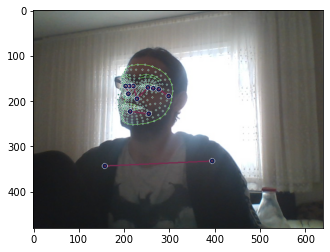

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose, face, lh, rh])

# 4. Setup Folders for Collection

In [9]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hello', 'thanks', 'iloveyou'])

#30 video ve her video 30 frame 
no_sequences = 30
sequence_lenght = 30

In [12]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [13]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_lenght):
                #görüntüyü oku
                ret, frame = cap.read()

                #noktaları tespit et
                frame, results = mediapipe_detection(frame, holistic)
                
                #sonuçları çizdir
                draw_styled_landmarks(frame, results)

                if frame_num == 0:
                    cv2.putText(frame, 'STARTING COLLECTION', (120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Real Time', frame)
                    cv2.waitKey(2000)
                    
                else: 
                    cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Real Time', frame)
                    
                
                keypoints = extract_keypoints(results)
                np_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(np_path, keypoints)
                
                
                #döngüyü sonlandır
                if cv2.waitKey(5) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
label_map = {label:num for num,label in enumerate(actions)}
print(label_map)

{'hello': 0, 'thanks': 1, 'iloveyou': 2}


In [22]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_lenght):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f'{str(frame_num)}.npy'))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

90, 30, 1662 // 90 -> üç işaretinde hepsinin iç içe olduğu, 30 -> 30 frame, 1662 landmark

In [29]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [31]:
X.shape

(90, 30, 1662)

In [32]:
y.shape

(90, 3)

# 7. Build and Train LSTM Neural Network


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [44]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [45]:
model = Sequential()
model.add(LSTM(64, return_sequences = True, activation = 'relu', input_shape = (30,1662)))
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(LSTM(64, return_sequences = False, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(actions.shape[0], activation = 'softmax'))

In [46]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [48]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 1s 356ms/step - loss: 0.6016 - categorical_accuracy: 0.8471
Epoch 2/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.5442 - categorical_accuracy: 0.7765
Epoch 3/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.5409 - categorical_accuracy: 0.7647
Epoch 4/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.4169 - categorical_accuracy: 0.8706
Epoch 5/2000
3/3 [==============================] - 0s 70ms/step - loss: 0.4278 - categorical_accuracy: 0.8471
Epoch 6/2000
3/3 [==============================] - 0s 69ms/step - loss: 0.4174 - categorical_accuracy: 0.9176
Epoch 7/2000
3/3 [==============================] - 0s 77ms/step - loss: 0.3701 - categorical_accuracy: 0.9176
Epoch 8/2000
3/3 [==============================] - 0s 59ms/step - loss: 0.4214 - categorical_accuracy: 0.9059
Epoch 9/2000
3/3 [==============================] - 0s 63ms/step - loss: 0.4339 - categorical_accuracy: 0.9059


KeyboardInterrupt: 

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

# 8. Make Predictions

In [50]:
res = model.predict(X_test)

In [51]:
actions[np.argmax(res[0])]

'thanks'

In [55]:
actions[np.argmax(y_test[0])]

'thanks'

# 9. Save Weights

In [56]:
model.save('action.h5')

# 10. Evaluation using a Confusion Matrix

In [65]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [58]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 385ms/step - loss: 0.1591 - categorical_accuracy: 1.0000


[0.15907856822013855, 1.0]

In [60]:
y_pred = model.predict(X_test)

In [69]:
mcm = multilabel_confusion_matrix(np.argmax(y_test, axis = 1).tolist(), np.argmax(y_pred, axis = 1).tolist())

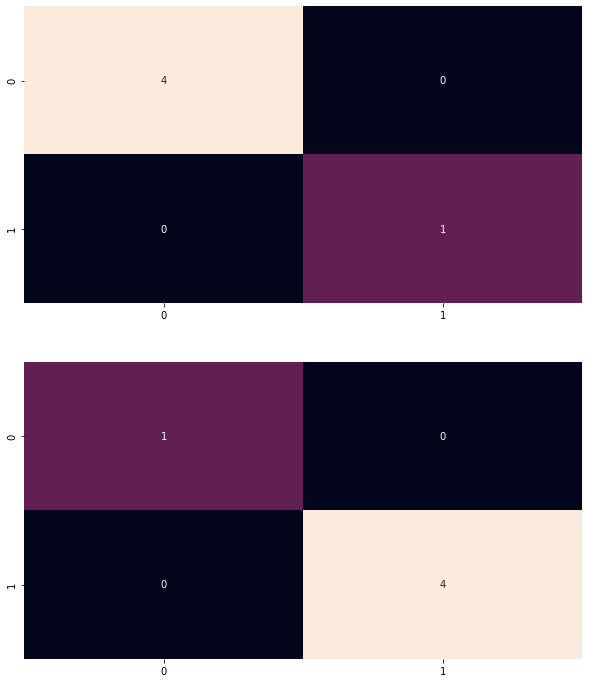

In [104]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (10,12));
sns.heatmap(mcm[0], annot=True, cbar=False, ax = ax1);
sns.heatmap(mcm[1], annot=True, cbar=False, ax = ax2);

# 11. Test in Real Time

In [139]:
colors = [(245,117,16),(117,245,16),(16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in  enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

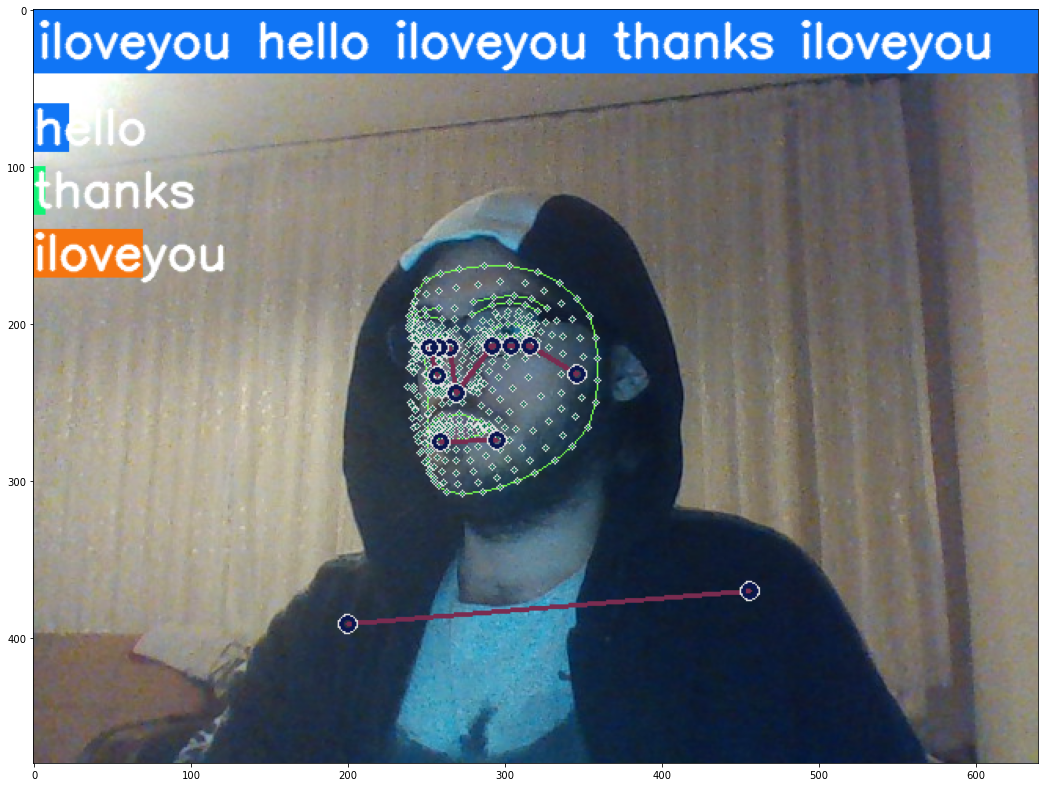

In [141]:
plt.figure(figsize=(18,18))
plt.imshow(cv2.cvtColor(prob_viz(res, actions, frame, colors), cv2.COLOR_BGR2RGB))

In [157]:
sequence = []
sentence = []
predictions = []
threshold = 0.85

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #görüntüyü oku
        ret, frame = cap.read()

        #noktaları tespit et
        frame, results = mediapipe_detection(frame, holistic)
        
        #sonuçları çizdir
        draw_styled_landmarks(frame, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        #30 frame sonrası tahmin yapar 
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis = 0))[0]
            predictions.append(np.argmax(res))
            
            #10 değer içinde 1 2 tane kazaara farklı bir şey karışırsa onu eklemesin diye 10 taneyi kontrol ediyor
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                #tahmin değeri thresholddan büyükse girer
                if res[np.argmax(res)] > threshold:

                    #cümle 0 dan büyükse girer
                    if len(sentence) > 0:

                        #cümledeki son kelime tahmin ile aynı değil ise girer
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])

                    #değil ise tahmin edilen action'ı ekler
                    else:
                        sentence.append(actions[np.argmax(res)])
            
            #cümle uzunluğu 5ten uzunsa son kelimeyi tekrar cümle yapar
            if len(sentence) > 5:
                sentence = sentence[-5:]
                
            frame = prob_viz(res, actions, frame, colors)
        
        #ekrana bu cümleyi yazdırır
        cv2.rectangle(frame, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(frame, ' '.join(sentence), (3,30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
               
        #ekranda göster
        cv2.imshow('Real Time', frame)

        #döngüyü sonlandır
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()